In [1]:
# mengimporkan berbagai library yang diperlukan
# untuk memanipulasi gambar, pemrosesan data, pembuatan
# model, visualisasi, dan evaluasi model

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,  classification_report, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import math, os, sys
import itertools
plt.style.use('default')
from scipy import ndimage
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from sklearn.model_selection import train_test_split


In [2]:
# mengetest dataset dan menampilkan gambar contohnya
# dengan menetapkan direktori dasar dataset, menentukan subdirektori
# untuk setiap kelas, membaca dan menampilkan contoh gambar

base_dir = "D:\penelitian arya\dataset penelitian\Train"

subdirs = ["Buah Sakit", "Buah Sehat", "Daun Gemini", 
           "Daun Keriting", "Daun Mosaic", "Daun Sehat", 
           "Kutu Kebul"]


<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_11280\1885347937.py:5: SyntaxWarning: invalid escape sequence '\p'
  base_dir = "D:\penelitian arya\dataset penelitian\Train"


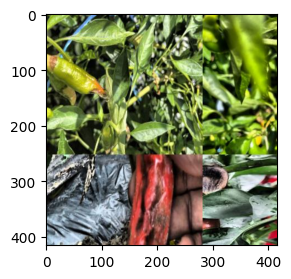

In [3]:
image = imread("D:/penelitian arya/dataset penelitian/Train/Buah Sakit/IMG_0219_JPG.rf.a12fb5cefc6b6ff1a708f81327b655dc.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [4]:
# membaca jalur file gambar dan label dari direktori dataset.
# kemudian menggabungkan jalur file dan label ke dalam df untuk
# analisis lebih lanjut.

dir = "D:\\penelitian arya\\dataset penelitian\\Train"
filepaths = []
labels = []
classlist = os.listdir(dir)
for klass in classlist:
    classpath=os.path.join(dir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths      labels
0  D:\penelitian arya\dataset penelitian\Train\Bu...  Buah Sakit
1  D:\penelitian arya\dataset penelitian\Train\Bu...  Buah Sakit
2  D:\penelitian arya\dataset penelitian\Train\Bu...  Buah Sakit
3  D:\penelitian arya\dataset penelitian\Train\Bu...  Buah Sakit
4  D:\penelitian arya\dataset penelitian\Train\Bu...  Buah Sakit
labels
Daun Sehat       1032
Buah Sakit        612
Daun Mosaic       600
Buah Sehat        500
Daun Keriting     467
Daun Gemini       144
Kutu Kebul        100
Name: count, dtype: int64


In [5]:
# Menentukan proporsi untuk data train dan valid
train_split = 0.8
valid_split = 0.2

# Membagi data menjadi data train dan valid
train_df, valid_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Mencetak jumlah baris dari setiap dataframe
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))

train_df length:  2764   valid_df length:  691


In [6]:
# menyiapkan generator data dan augmentasi
# mengatur parameter gambar  

# Parameter
img_width, img_height = 128, 128
batch_size = 64
test_batch_size=64
channels=3
num_classes = 7 # jumlah kelas


In [7]:
# mengatur data generator untuk
# augmentasi dan normalisasi.
# menginisialisasi generator untuk pelatihan dan validasi

# Augmentasi data
img_shape=(img_width, img_height, channels)
img_size=(img_width, img_height)

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Generator untuk membaca gambar 
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical' # Menggunakan categorical untuk klasifikasi multiklas
)

validation_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size
)

print("Class indices:", train_generator.class_indices)

Found 2764 validated image filenames belonging to 7 classes.
Found 691 validated image filenames belonging to 7 classes.
Class indices: {'Buah Sakit': 0, 'Buah Sehat': 1, 'Daun Gemini': 2, 'Daun Keriting': 3, 'Daun Mosaic': 4, 'Daun Sehat': 5, 'Kutu Kebul': 6}


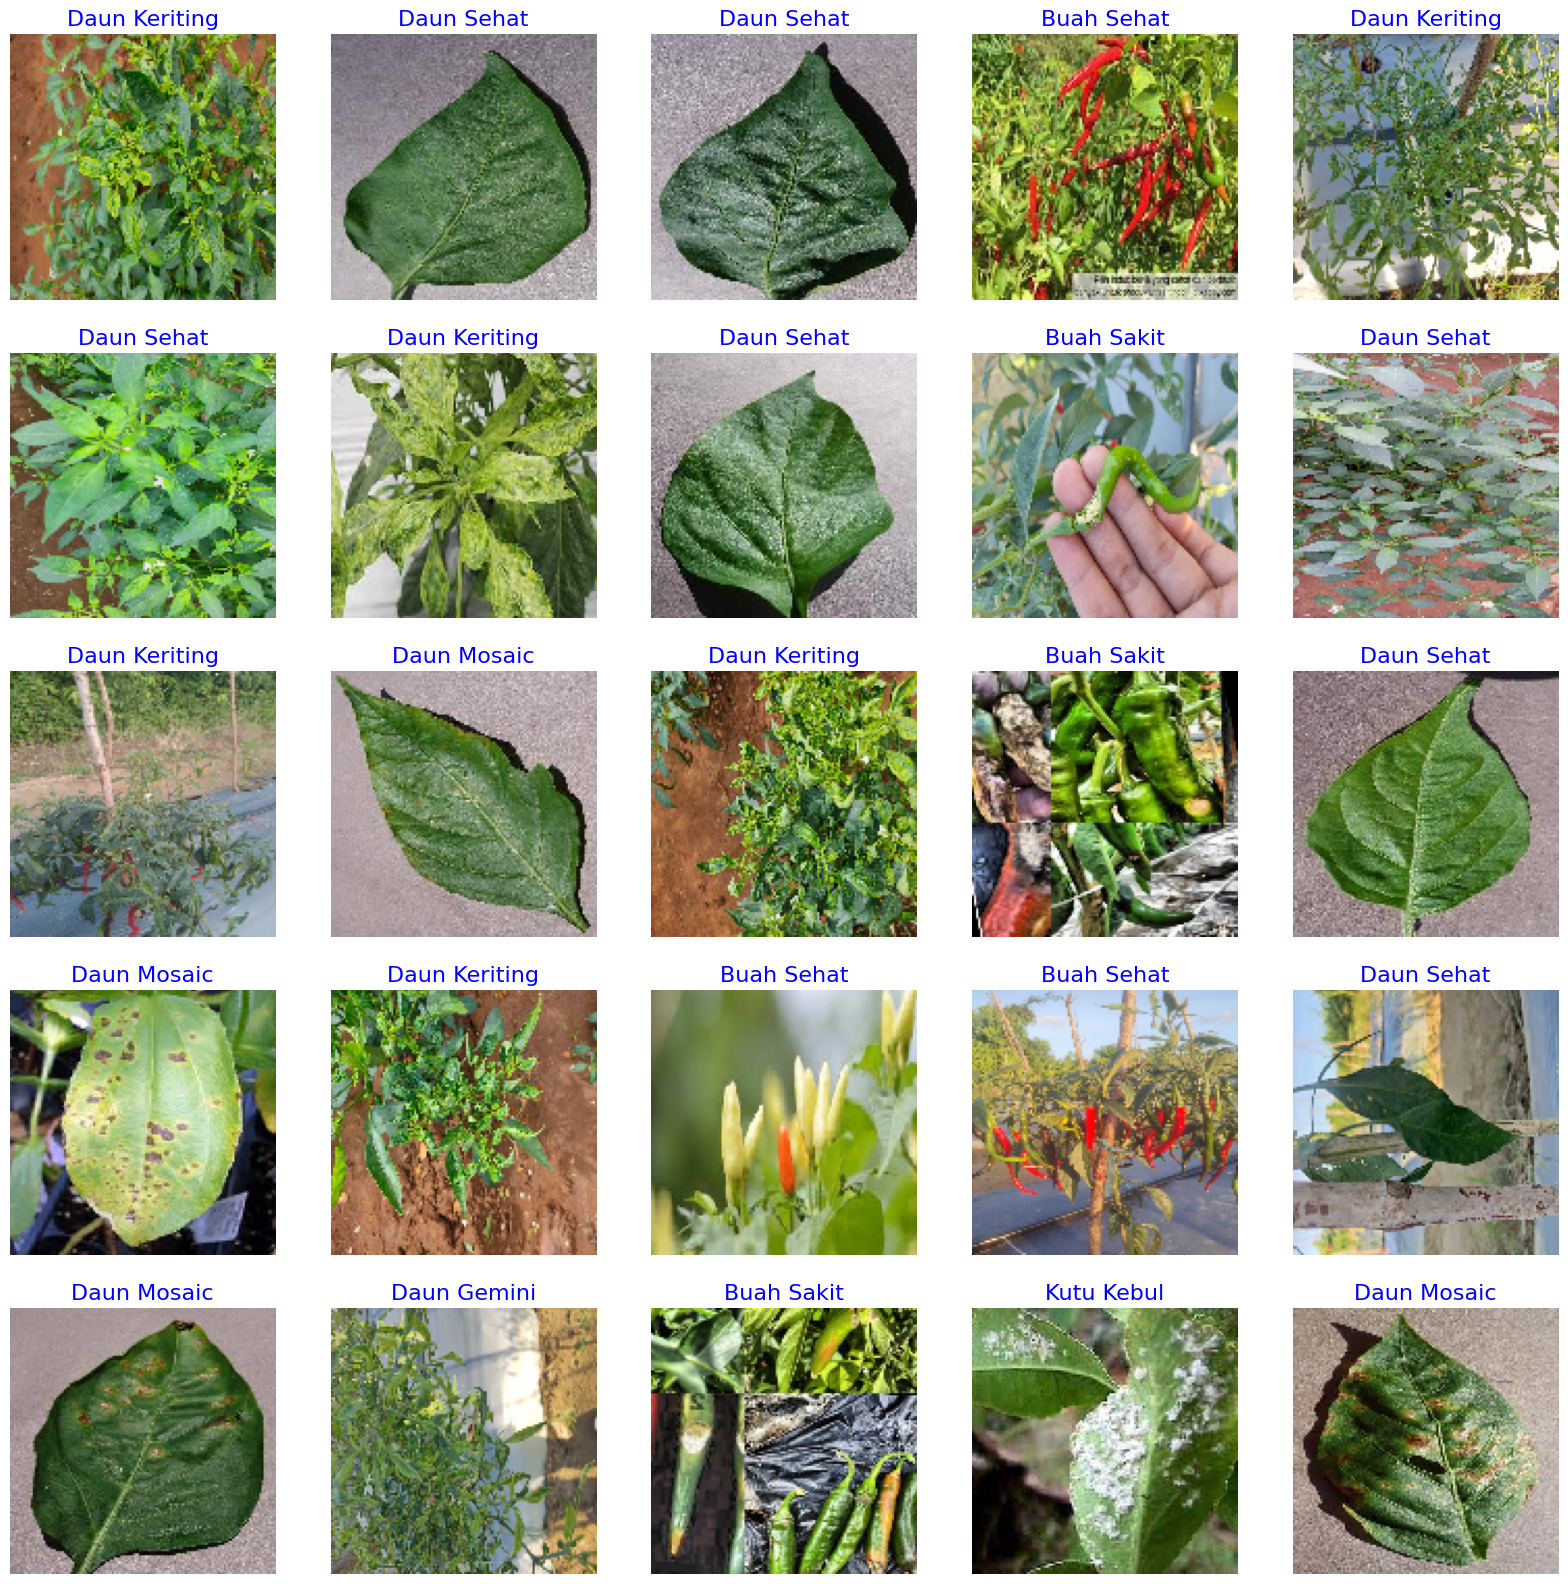

In [8]:
# menampilkan sampel gambar dari generator data untuk
# memeriksa augmentasi dan label

def show_image_samples(gen):
    test_dict=train_generator.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_generator)

In [9]:
# memanggil transfer learning vgg16 untuk pembuatan model
# dimana vgg16 merupakan model pre-trained tanpa lapisan atas untuk transfer learning

# Menggunakan Pre-trained Model (Transfer Learning)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, 
                   input_shape=(img_width, img_height, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Membangun model cnn dengan menambahkan beberapa lapisan untuk 
# klasifikasi.
# menjalankan model dengan optimizer Adam dan loss function categorical 
# crossentropy.
model = Sequential([

# mengambil ekstraksi fitur seperti warna RGB secara otomatis 
# melalui Conv2D atau lapisan Convolusi pertama
base_model,
Conv2D(filters=32, padding='same', kernel_size=3, 
       activation='relu', strides=1),
MaxPooling2D(pool_size=2, strides=2),
Dropout(0.5),
Flatten(),
Dense(num_classes, activation='softmax')
])

# lapisan untuk mengkompilasi atau menjalankan model
optimizer = Adam(learning_rate=0.0001)  # Mengatur learning rate
model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()





Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# Callbacks
# Early stopping atau pemberhentian secara otomatis 
# jika model yang di train tidak kunjung mengalami peningkatan dalam accuracy-nya
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [12]:
# melatih model dengan memanggil callback untuk early stopping
# dan reduksi rate.
# melatih model dan menyimpan model yang telah dilatih.

epochs = 5 

history = model.fit(x=train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/5


c:\Users\PC-04\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.2417 - loss: 1.9804 - val_accuracy: 0.5109 - val_loss: 1.3819
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4643 - loss: 1.3744 - val_accuracy: 0.6556 - val_loss: 1.1724
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5441 - loss: 1.2158 - val_accuracy: 0.6874 - val_loss: 1.0551
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6016 - loss: 1.1075 - val_accuracy: 0.7048 - val_loss: 0.9532
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6339 - loss: 0.9826 - val_accuracy: 0.7207 - val_loss: 0.8877


In [13]:
# Menyimpan model
# model.save('plant_disease_cnn_baru1.h5')

<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_11280\3936153220.py:37: SyntaxWarning: invalid escape sequence '\p'
  folder_path = 'D:\penelitian arya\Tes\Tes5'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_11280\3936153220.py:38: SyntaxWarning: invalid escape sequence '\p'
  model_path = 'D:\penelitian arya\plant_disease_cnn_baru.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


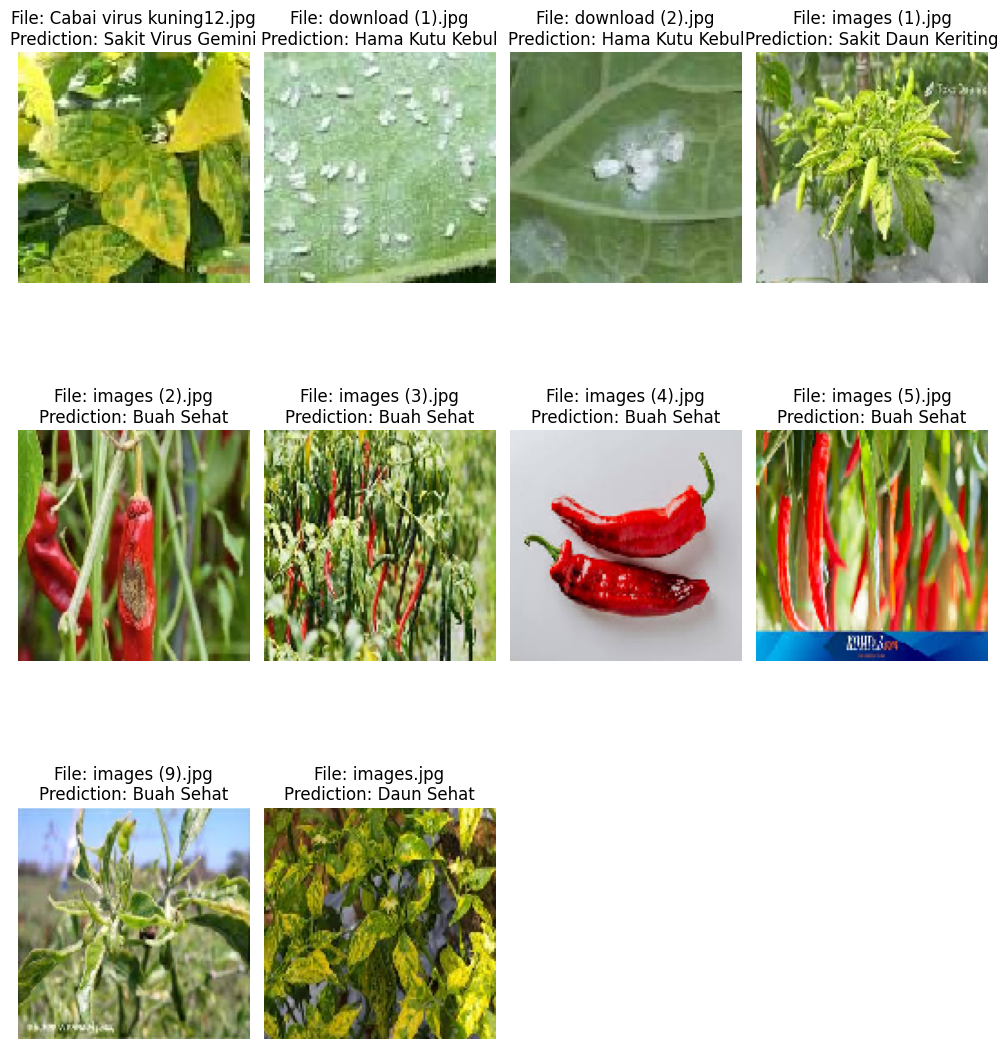

In [14]:
# Fungsi untuk memprediksi gambar dan menampilkannya 
# dengan memuat model yang telah dilatih.
# mendefinisikan fungsi untuk memprediksi gambar dalam folder
# tertentu dan menampilkan hasilnya.
def predict_and_show_images_in_folder(folder_path, model, class_labels):
    try:
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
        num_images = len(image_files)
        num_columns = 4
        num_rows = num_images // num_columns + (num_images % num_columns != 0)
        
        plt.figure(figsize=(10, num_rows * 4))
        
        for i, filename in enumerate(image_files):
            image_path = os.path.join(folder_path, filename)
            img = load_img(image_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255

            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            result = class_labels[predicted_class]

            plt.subplot(num_rows, num_columns, i + 1)
            plt.imshow(img)
            plt.title(f'File: {filename}\nPrediction: {result}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# pemanggilan folder input & model
folder_path = 'D:\penelitian arya\Tes\Tes5'  
model_path = 'D:\penelitian arya\plant_disease_cnn_baru.h5'  
img_width, img_height = 128, 128

# Daftar label kelas 
class_labels = ['Sakit Antraknosa', 'Buah Sehat', 'Sakit Virus Gemini', 'Sakit Daun Keriting',
                'Sakit Daun Mosaic', 'Daun Sehat', 'Hama Kutu Kebul']  

# Memuat model
model = load_model(model_path)

# Memanggil fungsi predict_and_show_images_in_folder
predict_and_show_images_in_folder(folder_path, model, class_labels)

In [15]:
# Menampilkan grafik akurasi dan loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


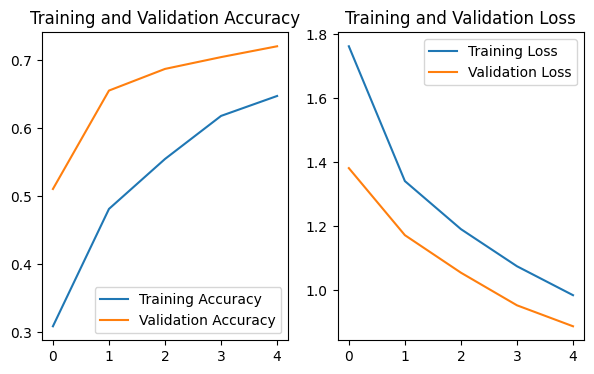

In [16]:
# Plot training history
plot_training_history(history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


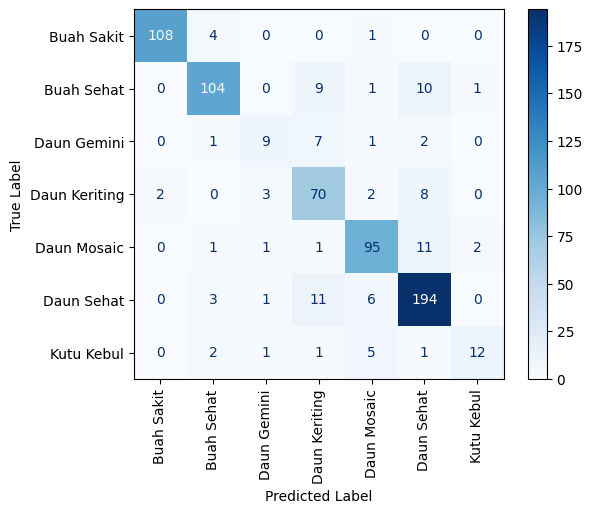

Confusion Matrix
[[108   4   0   0   1   0   0]
 [  0 104   0   9   1  10   1]
 [  0   1   9   7   1   2   0]
 [  2   0   3  70   2   8   0]
 [  0   1   1   1  95  11   2]
 [  0   3   1  11   6 194   0]
 [  0   2   1   1   5   1  12]]
Classification Report
               precision    recall  f1-score   support

   Buah Sakit       0.98      0.96      0.97       113
   Buah Sehat       0.90      0.83      0.87       125
  Daun Gemini       0.60      0.45      0.51        20
Daun Keriting       0.71      0.82      0.76        85
  Daun Mosaic       0.86      0.86      0.86       111
   Daun Sehat       0.86      0.90      0.88       215
   Kutu Kebul       0.80      0.55      0.65        22

     accuracy                           0.86       691
    macro avg       0.82      0.77      0.78       691
 weighted avg       0.86      0.86      0.86       691

Precision: 0.8585
Recall: 0.8567
F1-Score: 0.8555


In [17]:
# menampilkan tabel convusion matrix
def evaluate_model_on_validation(model, validation_generator):
    # Predict validation data
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print('Confusion Matrix')
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Classification Report
    print('Classification Report')
    target_names = list(validation_generator.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=target_names))

     # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

# Evaluasi model dan tampilkan metrik
evaluate_model_on_validation(model, validation_generator)